In [1]:
!pip install fasttext -q
!pip install gensim -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 41.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [2]:
import torch
import random
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel

2025-05-17 16:18:19.404216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747498699.591884      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747498699.650805      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
model_path = "/kaggle/input/wikinews300d1msubwordvec/wiki-news-300d-1M-subword.vec"
fasttext_model = KeyedVectors.load_word2vec_format(model_path)

In [9]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv', encoding='latin1', header=None, names=['label', 'headline'])
df.head()

,label,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [10]:
def process_text(text):
    if not isinstance(text, str):
        return None
    tokens = word_tokenize(text.lower())
    stemmed_tokens = [stemmer.stem(t) for t in tokens]
    return stemmed_tokens

def vectorize(tokens):
    vectors = []
    mask = []
    for t in tokens[:MAX_LEN]:
        if t in fasttext_model:
            vectors.append(fasttext_model[t])
        else:
            vectors.append(PAD_VECTOR)
        mask.append(1) 

    while len(vectors) < MAX_LEN:
        vectors.append(PAD_VECTOR)
        mask.append(0) 

    return np.stack(vectors), np.array(mask)

In [57]:
token_lengths = []
news, labels, masks = [], [], []

MAX_LEN = 32
EMBEDDING_DIM = 300
PAD_VECTOR = np.zeros(EMBEDDING_DIM)

stemmer = PorterStemmer()

for _, row in df.iterrows():
    text = row[1]
    tokens = process_text(text)

    if tokens is None or len(tokens) == 0:
        continue

    token_lengths.append(len(tokens))

    embeddings, mask = vectorize(tokens)
    news.append(np.array(embeddings))
    labels.append(row[0])
    masks.append(mask)

/tmp/ipykernel_35/130943665.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1]
/tmp/ipykernel_35/130943665.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[0])


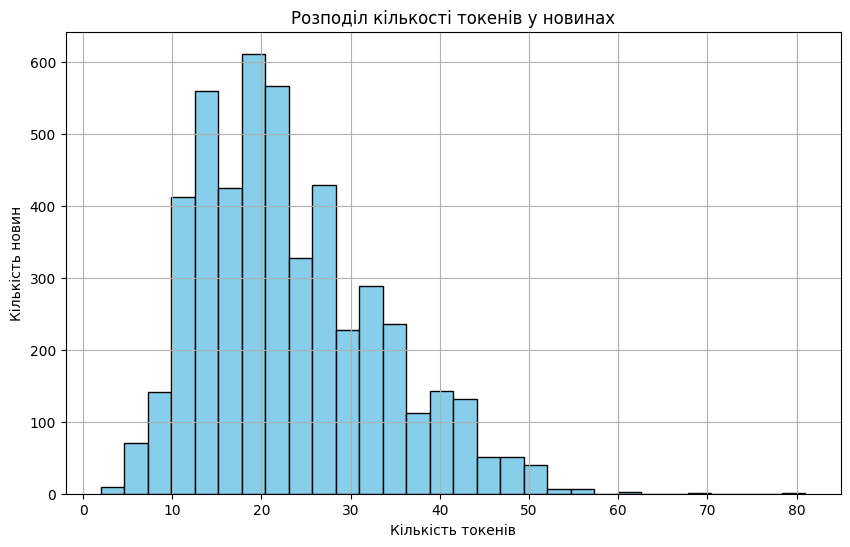

In [58]:
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Розподіл кількості токенів у новинах")
plt.xlabel("Кількість токенів")
plt.ylabel("Кількість новин")
plt.grid(True)
plt.show()

In [59]:
news = np.array(news)
labels = np.array(labels)
masks = np.array(masks)
print(news.shape)

(4846, 32, 300)


In [60]:
count_0 = np.sum(labels == 'negative')
count_1 = np.sum(labels == 'neutral')
count_2 = np.sum(labels == 'positive')

print(" negative, neutral, positive", count_0, count_1, count_2)

 negative, neutral, positive 0 0 0


In [61]:
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(news, labels_encoded, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [63]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [64]:
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    news, labels_encoded, masks, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val, masks_train, masks_val = train_test_split(
    X_train, y_train, masks_train, test_size=0.1, random_state=42)\

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
masks_train_tensor = torch.tensor(masks_train, dtype=torch.bool)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
masks_val_tensor = torch.tensor(masks_val, dtype=torch.bool)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
masks_test_tensor = torch.tensor(masks_test, dtype=torch.bool)

train_dataset = TensorDataset(X_train_tensor, masks_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, masks_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, masks_test_tensor, y_test_tensor)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [65]:
def seed_everything(seed_value=0):
    random.seed(seed_value)  
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value) 
    torch.cuda.manual_seed(seed_value) 
    torch.cuda.manual_seed_all(seed_value) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 

In [66]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, drop_prob, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.dropout = nn.Dropout(drop_prob)
        self.batchnorm = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.dropout(out)
        out = self.batchnorm(out)
        out = F.relu(out)
        return out


class FractalBlock(nn.Module):
    def __init__(self, n_columns, input_channels, output_channels, kernel_size, local_drop_prob, dropout_prob,
                 global_drop_prob, training=True):
        super().__init__()
        self.n_columns = n_columns
        self.columns = nn.ModuleList([nn.ModuleList() for _ in range(n_columns)])
        self.max_depth = 2 ** (n_columns - 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.local_drop_prob = local_drop_prob
        self.global_drop_prob = global_drop_prob
        self.count = np.zeros([self.max_depth], dtype=int)
        dist = self.max_depth
        for col in self.columns:
            for i in range(self.max_depth):
                if (i + 1) % dist == 0:
                    first_block = (i + 1 == dist)
                    if first_block:
                        cur_input = input_channels
                    else:
                        cur_input = output_channels

                    module = ConvBlock(cur_input, output_channels, kernel_size, dropout_prob)
                    self.count[i] += 1
                else:
                    module = None
                col.append(module)
            dist //= 2

    def drop_mask(self, B, global_cols, n_cols):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if isinstance(global_cols, np.ndarray):
            global_cols = torch.tensor(global_cols, device=device)
        
        GB = global_cols.shape[0]
        gdrop_cols = global_cols - (self.n_columns - n_cols)
        gdrop_indices = torch.where(gdrop_cols >= 0)[0]
        
        gdrop_mask = torch.zeros(n_cols, GB, device=device, dtype=torch.float32)
        if gdrop_indices.shape[0] > 0:
            gdrop_mask[gdrop_cols[gdrop_indices], gdrop_indices] = 1.0
            
        LB = B - GB
        prob_tensor = torch.ones(n_cols, LB, device=device) * (1. - self.local_drop_prob)
        ldrop_mask = torch.bernoulli(prob_tensor)
        alive_count = ldrop_mask.sum(dim=0)
        
        dead_indices = torch.where(alive_count == 0.)[0]
        if dead_indices.shape[0] > 0:
            random_rows = torch.randint(0, n_cols, (dead_indices.shape[0],), device=device)
            ldrop_mask[random_rows, dead_indices] = 1.0
        drop_mask = torch.cat((gdrop_mask, ldrop_mask), dim=1)
        return drop_mask

    def join(self, outs, global_cols):
        n_cols = len(outs)
        out = torch.stack(outs) 

        if self.training:
            mask = self.drop_mask(out.size(1), global_cols, n_cols).to(out.device)  # [n_cols, B]
            mask = mask.view(*mask.size(), 1, 1) 
            n_alive = mask.sum(dim=0)  
            masked_out = out * mask  
            n_alive[n_alive == 0.] = 1.
            out = masked_out.sum(dim=0) / n_alive  
        else:
            out = out.mean(dim=0)
        return out

    def forward(self, x, global_cols):
        outs = [x] * self.n_columns
        for i in range(self.max_depth):
            st = self.n_columns - self.count[i]
            cur_outs = []

            for c in range(st, self.n_columns):
                cur_in = outs[c]
                cur_module = self.columns[c][i]
                if cur_module is not None:
                    cur_outs.append(cur_module(cur_in))

            joined = self.join(cur_outs, global_cols)

            for c in range(st, self.n_columns):
                outs[c] = joined

        outs[-1] = self.dropout(outs[-1])
        return outs[-1]

class FractalNet(nn.Module):
    def __init__(self, n_blocks, n_columns, out_channels, kernel_size, local_drop_prob, drop_prob,
                 global_drop_prob, embedding_dim):
        super().__init__()
        self.n_blocks = n_blocks
        self.n_columns = n_columns
        self.out_channels = out_channels
        self.local_drop_prob = local_drop_prob
        self.global_drop_prob = global_drop_prob

        self.layers = nn.ModuleList()
        total_layers = 0

        current_channels = embedding_dim
        for i in range(self.n_blocks):
            print(f"Block {i + 1}, Input channels: {current_channels}, Output channels: {out_channels[i]}")
            fractal_block = FractalBlock(n_columns, current_channels, out_channels[i], kernel_size,
                                         local_drop_prob, drop_prob, global_drop_prob)
            self.layers.append(fractal_block)
            self.layers.append(nn.BatchNorm1d(out_channels[i]))
            current_channels = out_channels[i]
            total_layers += fractal_block.max_depth

        self.initialize_weights()
        print(f"Total layers in network: {total_layers}")

    def initialize_weights(self):
        for name, param in self.named_parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
            else:
                if 'bn.weight' in name:
                    nn.init.ones_(param)
                elif 'bn.bias' in name or 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        B, T, E = x.shape             
        x = x.permute(0, 2, 1)  

        GB = int(x.size(0) * self.global_drop_prob)
        global_cols = None

        out = x
        for layer in self.layers:
            if isinstance(layer, FractalBlock):
                global_cols = np.random.randint(0, self.n_columns, size=[GB])
                out = layer(out, global_cols)  
            else:
                out = layer(out)              

        out = out.permute(0, 2, 1)
        return out

In [67]:
class NewsAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=1, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads,
                                          dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
    
        key_padding_mask = ~mask
        attn_output, attn_weights = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        out = self.norm(x + self.dropout(attn_output))
        pooled = out.mean(dim=1)
        return pooled, attn_weights

In [68]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=(1024, 512), dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], 3)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x) 
        return x

In [69]:
class NewsModel(nn.Module):
    def __init__(self, embedding_dim, n_blocks, n_columns, out_channels, kernel_size, 
                 local_drop_prob, drop_prob, global_drop_prob, mlp_hidden_dims, dropout):
        super().__init__()
        
        self.fractal_net = FractalNet(
            n_blocks=n_blocks,
            n_columns=n_columns,
            out_channels=out_channels,
            kernel_size=kernel_size,
            local_drop_prob=local_drop_prob,
            drop_prob=drop_prob,
            global_drop_prob=global_drop_prob,
            embedding_dim=embedding_dim
        )
        
        fractal_output_dim = out_channels[-1]
        
        self.attention = NewsAttention(
            embed_dim=fractal_output_dim,
            num_heads=4, 
            dropout=dropout
        )
        
        self.classifier = Classifier(
            input_dim=fractal_output_dim,
            hidden_dims=mlp_hidden_dims,
            dropout=dropout
        )
        
    def forward(self, x, mask):
        fractal_output = self.fractal_net(x) 
        attention_output, attention_weights = self.attention(fractal_output, mask)
        logits = self.classifier(attention_output)
        return logits

In [70]:
def train(model, train_loader, val_loader, num_epoch, optimizer, criterion, device, patience=10):
    best_f1 = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epoch):
        model.train()
        train_loss = 0.0
        y_true_train = []
        y_pred_train = []

        for batch in train_loader:
            tokens, masks, targets = batch
            tokens = tokens.to(device)
            masks = masks.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(tokens, masks)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * tokens.size(0)

            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            preds = probs.argmax(axis=1)

            y_pred_train.extend(preds)
            y_true_train.extend(targets.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_report = classification_report(y_true_train, y_pred_train, output_dict=True, zero_division=0)

        model.eval()
        val_loss = 0.0
        y_true_val = []
        y_pred_val = []

        with torch.no_grad():
            for batch in val_loader:
                tokens, masks, targets = batch
                tokens = tokens.to(device)
                masks = masks.to(device)
                targets = targets.to(device)

                outputs = model(tokens, masks)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * tokens.size(0)

                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                preds = probs.argmax(axis=1)

                y_pred_val.extend(preds)
                y_true_val.extend(targets.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_report = classification_report(y_true_val, y_pred_val, output_dict=True, zero_division=0)
        val_f1 = val_report['weighted avg']['f1-score']

        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{num_epoch}:")
            print(f"  Train Precision: {train_report['weighted avg']['precision']:.4f}, "
                  f"Recall: {train_report['weighted avg']['recall']:.4f}, "
                  f"F1: {train_report['weighted avg']['f1-score']:.4f}")
            print(f"  Val Precision: {val_report['weighted avg']['precision']:.4f}, "
                  f"Recall: {val_report['weighted avg']['recall']:.4f}, "
                  f"F1: {val_f1:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return avg_train_loss, train_report, avg_val_loss, val_report

In [71]:
def test_model(model, test_dataloader, device, name):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in test_dataloader:
            tokens, masks, targets = batch
            tokens = tokens.to(device)
            masks = masks.to(device)
            targets = targets.to(device)

            outputs = model(tokens, masks)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = probs.argmax(axis=1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds)

    report = classification_report(y_true, y_pred, zero_division=0)
    print("Classification Report:\n", report)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig(name, dpi=300, bbox_inches='tight')  
    plt.show()

# Fine Tune FractalNet-ATTN

In [72]:
def validate(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for tokens, masks, labels in val_loader:
            tokens = tokens.to(device)
            masks = masks.to(device)
            labels = labels.to(device)
            
            outputs = model(tokens, masks) 
            loss = criterion(outputs, labels)
            running_loss += loss.item() * tokens.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / total
    val_accuracy = correct / total
    
    report = classification_report(all_labels, all_preds, digits=4)
    print("Classification Report:\n", report)
    
    return val_loss, val_accuracy, report

In [28]:
 device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [74]:
n_blocks_choices = [2, 3, 4]
n_columns_choices = [2, 3, 4]
base_out_channels_choices = [
    [16, 32, 64, 128],
    [32, 64, 128, 256],
    [64, 128, 256, 512]
]
local_drop_prob_choices = [0.0, 0.3, 0.5]
drop_prob_choices = [0.0, 0.1, 0.3, 0.4, 0.5]
global_drop_prob_choices = [0.0, 0.1, 0.3, 0.4, 0.5]
dropout_choices = [0.0, 0.1, 0.3]
lr_choices = [1e-5, 1e-4, 1e-3]

def sample_params():
    n_blocks = random.choice(n_blocks_choices)
    n_columns = random.choice(n_columns_choices)
    base_out_channels = random.choice(base_out_channels_choices)
    out_channels = base_out_channels[:n_blocks]

    return {
        'n_blocks': n_blocks,
        'n_columns': n_columns,
        'out_channels': out_channels,
        'local_drop_prob': random.choice(local_drop_prob_choices),
        'drop_prob': random.choice(drop_prob_choices),
        'global_drop_prob': random.choice(global_drop_prob_choices),
        'dropout': random.choice(dropout_choices),
        'lr': random.choice(lr_choices),
        'kernel_size': 3,
        'embedding_dim': 300
    }

best_accuracy = 0
best_params = None
num_trials = 20

for trial in range(num_trials):
    params = sample_params()
    print(f"Trial {trial+1}/{num_trials}: {params}")

    model = NewsModel(
        embedding_dim=params['embedding_dim'],
        n_blocks=params['n_blocks'],
        n_columns=params['n_columns'],
        out_channels=params['out_channels'],
        kernel_size=params['kernel_size'],
        local_drop_prob=params['local_drop_prob'],
        drop_prob=params['drop_prob'],
        global_drop_prob=params['global_drop_prob'],
        mlp_hidden_dims=[128, 128],
        dropout=params['dropout'],
    ).to(device)

    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'])
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    train(model, train_loader, val_loader, num_epoch=50, optimizer=optimizer,
          criterion=criterion, device=device, patience=10) 

    val_loss, val_accuracy, report = validate(model, val_loader, criterion, device)

    print(f"Validation accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

print(f"\nBest accuracy: {best_accuracy:.4f}")
print(f"Best params: {best_params}")

Trial 1/20: {'n_blocks': 3, 'n_columns': 3, 'out_channels': [64, 128, 256], 'local_drop_prob': 0.0, 'drop_prob': 0.5, 'global_drop_prob': 0.1, 'dropout': 0.1, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Block 3, Input channels: 128, Output channels: 256
Total layers in network: 12


/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.3733, Recall: 0.2768, F1: 0.1264
  Val Precision: 0.0164, Recall: 0.1281, F1: 0.0291
Epoch 50/50:
  Train Precision: 0.5277, Recall: 0.4972, F1: 0.4827
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        56
           1     0.5721    1.0000    0.7278       250
           2     0.0000    0.0000    0.0000       131

    accuracy                         0.5721       437
   macro avg     0.1907    0.3333    0.2426       437
weighted avg     0.3273    0.5721    0.4164       437

Validation accuracy: 0.5721
Trial 2/20: {'n_blocks': 2, 'n_columns': 4, 'out_channels': [32, 64], 'local_drop_prob': 0.5, 'drop_prob': 0.5, 'global_drop_prob': 0.1, 'dropout': 0.1, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Total layers in network: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy constru

Epoch 1/50:
  Train Precision: 0.4639, Recall: 0.5938, F1: 0.4511
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Epoch 50/50:
  Train Precision: 0.4737, Recall: 0.4327, F1: 0.4367
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        56
           1     0.5721    1.0000    0.7278       250
           2     0.0000    0.0000    0.0000       131

    accuracy                         0.5721       437
   macro avg     0.1907    0.3333    0.2426       437
weighted avg     0.3273    0.5721    0.4164       437

Validation accuracy: 0.5721
Trial 3/20: {'n_blocks': 4, 'n_columns': 2, 'out_channels': [64, 128, 256, 512], 'local_drop_prob': 0.3, 'drop_prob': 0.4, 'global_drop_prob': 0.5, 'dropout': 0.0, 'lr': 0.0001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Block 3, Inp

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy constru

Epoch 1/50:
  Train Precision: 0.4803, Recall: 0.2554, F1: 0.2592
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Epoch 50/50:
  Train Precision: 0.6321, Recall: 0.6478, F1: 0.6293
  Val Precision: 0.4265, Recall: 0.6133, F1: 0.4988
Classification Report:
               precision    recall  f1-score   support

           0     0.5600    0.5000    0.5283        56
           1     0.6202    0.9600    0.7535       250
           2     0.0000    0.0000    0.0000       131

    accuracy                         0.6133       437
   macro avg     0.3934    0.4867    0.4273       437
weighted avg     0.4265    0.6133    0.4988       437

Validation accuracy: 0.6133
Trial 4/20: {'n_blocks': 3, 'n_columns': 3, 'out_channels': [64, 128, 256], 'local_drop_prob': 0.5, 'drop_prob': 0.1, 'global_drop_prob': 0.5, 'dropout': 0.1, 'lr': 0.0001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Block 3, Input ch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy constru

Epoch 1/50:
  Train Precision: 0.4981, Recall: 0.2750, F1: 0.2966
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Epoch 50/50:
  Train Precision: 0.6977, Recall: 0.6893, F1: 0.6902
  Val Precision: 0.6963, Recall: 0.6773, F1: 0.6317
Classification Report:
               precision    recall  f1-score   support

           0     0.5270    0.6964    0.6000        56
           1     0.7025    0.9160    0.7951       250
           2     0.7568    0.2137    0.3333       131

    accuracy                         0.6773       437
   macro avg     0.6621    0.6087    0.5762       437
weighted avg     0.6963    0.6773    0.6317       437

Validation accuracy: 0.6773
Trial 5/20: {'n_blocks': 4, 'n_columns': 3, 'out_channels': [16, 32, 64, 128], 'local_drop_prob': 0.5, 'drop_prob': 0.0, 'global_drop_prob': 0.0, 'dropout': 0.3, 'lr': 0.0001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 16
Block 2, Input channels: 16, Output channels: 32
Block 3, Input 

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.4665, Recall: 0.2194, F1: 0.2214
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Epoch 50/50:
  Train Precision: 0.6578, Recall: 0.6425, F1: 0.6447
  Val Precision: 0.6128, Recall: 0.6064, F1: 0.6036
Classification Report:
               precision    recall  f1-score   support

           0     0.4565    0.7500    0.5676        56
           1     0.7437    0.7080    0.7254       250
           2     0.4299    0.3511    0.3866       131

    accuracy                         0.6064       437
   macro avg     0.5434    0.6030    0.5598       437
weighted avg     0.6128    0.6064    0.6036       437

Validation accuracy: 0.6064
Trial 6/20: {'n_blocks': 4, 'n_columns': 4, 'out_channels': [64, 128, 256, 512], 'local_drop_prob': 0.0, 'drop_prob': 0.5, 'global_drop_prob': 0.4, 'dropout': 0.1, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Block 3, Inpu

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.4282, Recall: 0.2406, F1: 0.2246
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Epoch 50/50:
  Train Precision: 0.4541, Recall: 0.3843, F1: 0.4099
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        56
           1     0.5721    1.0000    0.7278       250
           2     0.0000    0.0000    0.0000       131

    accuracy                         0.5721       437
   macro avg     0.1907    0.3333    0.2426       437
weighted avg     0.3273    0.5721    0.4164       437

Validation accuracy: 0.5721
Trial 7/20: {'n_blocks': 4, 'n_columns': 3, 'out_channels': [64, 128, 256, 512], 'local_drop_prob': 0.0, 'drop_prob': 0.1, 'global_drop_prob': 0.5, 'dropout': 0.0, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Block 3, Inpu

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy constru

Total layers in network: 16
Epoch 1/50:
  Train Precision: 0.4450, Recall: 0.3219, F1: 0.3477
  Val Precision: 0.4498, Recall: 0.4554, F1: 0.4380
Epoch 50/50:
  Train Precision: 0.5529, Recall: 0.5316, F1: 0.5133
  Val Precision: 0.6194, Recall: 0.6362, F1: 0.5570
Classification Report:
               precision    recall  f1-score   support

           0     0.4048    0.6071    0.4857        56
           1     0.6973    0.9400    0.8007       250
           2     0.5625    0.0687    0.1224       131

    accuracy                         0.6362       437
   macro avg     0.5549    0.5386    0.4696       437
weighted avg     0.6194    0.6362    0.5570       437

Validation accuracy: 0.6362
Trial 8/20: {'n_blocks': 2, 'n_columns': 4, 'out_channels': [32, 64], 'local_drop_prob': 0.0, 'drop_prob': 0.0, 'global_drop_prob': 0.3, 'dropout': 0.3, 'lr': 0.0001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 32
Block 2, Input channels: 32, Output channels:

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.4650, Recall: 0.3996, F1: 0.4098
  Val Precision: 0.4171, Recall: 0.5606, F1: 0.4378
Epoch 50/50:
  Train Precision: 0.8600, Recall: 0.8552, F1: 0.8564
  Val Precision: 0.6603, Recall: 0.6430, F1: 0.6442
Classification Report:
               precision    recall  f1-score   support

           0     0.6774    0.3750    0.4828        56
           1     0.7613    0.7400    0.7505       250
           2     0.4601    0.5725    0.5102       131

    accuracy                         0.6430       437
   macro avg     0.6330    0.5625    0.5812       437
weighted avg     0.6603    0.6430    0.6442       437

Validation accuracy: 0.6430
Trial 9/20: {'n_blocks': 2, 'n_columns': 3, 'out_channels': [64, 128], 'local_drop_prob': 0.3, 'drop_prob': 0.0, 'global_drop_prob': 0.5, 'dropout': 0.1, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.5033, Recall: 0.4980, F1: 0.4862
  Val Precision: 0.5399, Recall: 0.5858, F1: 0.5305
Epoch 50/50:
  Train Precision: 0.9220, Recall: 0.9179, F1: 0.9187
  Val Precision: 0.7726, Recall: 0.7735, F1: 0.7727
Classification Report:
               precision    recall  f1-score   support

           0     0.6800    0.6071    0.6415        56
           1     0.8294    0.8360    0.8327       250
           2     0.7037    0.7252    0.7143       131

    accuracy                         0.7735       437
   macro avg     0.7377    0.7228    0.7295       437
weighted avg     0.7726    0.7735    0.7727       437

Validation accuracy: 0.7735
Trial 10/20: {'n_blocks': 2, 'n_columns': 4, 'out_channels': [64, 128], 'local_drop_prob': 0.5, 'drop_prob': 0.3, 'global_drop_prob': 0.4, 'dropout': 0.0, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in networ

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.4764, Recall: 0.4549, F1: 0.4636
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Epoch 50/50:
  Train Precision: 0.6964, Recall: 0.6853, F1: 0.6864
  Val Precision: 0.6535, Recall: 0.6796, F1: 0.6575
Classification Report:
               precision    recall  f1-score   support

           0     0.4571    0.2857    0.3516        56
           1     0.7442    0.8960    0.8131       250
           2     0.5644    0.4351    0.4914       131

    accuracy                         0.6796       437
   macro avg     0.5886    0.5389    0.5520       437
weighted avg     0.6535    0.6796    0.6575       437

Validation accuracy: 0.6796
Trial 11/20: {'n_blocks': 3, 'n_columns': 3, 'out_channels': [64, 128, 256], 'local_drop_prob': 0.0, 'drop_prob': 0.3, 'global_drop_prob': 0.1, 'dropout': 0.0, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Block 3, Input ch

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.4767, Recall: 0.5831, F1: 0.4572
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Epoch 50/50:
  Train Precision: 0.5410, Recall: 0.5245, F1: 0.4919
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        56
           1     0.5721    1.0000    0.7278       250
           2     0.0000    0.0000    0.0000       131

    accuracy                         0.5721       437
   macro avg     0.1907    0.3333    0.2426       437
weighted avg     0.3273    0.5721    0.4164       437

Validation accuracy: 0.5721
Trial 12/20: {'n_blocks': 2, 'n_columns': 4, 'out_channels': [64, 128], 'local_drop_prob': 0.3, 'drop_prob': 0.4, 'global_drop_prob': 0.0, 'dropout': 0.0, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in networ

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy constru

Epoch 1/50:
  Train Precision: 0.5040, Recall: 0.4274, F1: 0.4425
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Epoch 50/50:
  Train Precision: 0.8035, Recall: 0.7903, F1: 0.7924
  Val Precision: 0.6323, Recall: 0.6453, F1: 0.5722
Classification Report:
               precision    recall  f1-score   support

           0     0.3333    0.0536    0.0923        56
           1     0.6404    0.9760    0.7734       250
           2     0.7447    0.2672    0.3933       131

    accuracy                         0.6453       437
   macro avg     0.5728    0.4322    0.4196       437
weighted avg     0.6323    0.6453    0.5722       437

Validation accuracy: 0.6453
Trial 13/20: {'n_blocks': 2, 'n_columns': 2, 'out_channels': [16, 32], 'local_drop_prob': 0.0, 'drop_prob': 0.5, 'global_drop_prob': 0.4, 'dropout': 0.3, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 16
Block 2, Input channels: 16, Output channels: 32
Total layers in network:

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.4588, Recall: 0.4052, F1: 0.4165
  Val Precision: 0.3406, Recall: 0.5355, F1: 0.4129
Epoch 50/50:
  Train Precision: 0.6079, Recall: 0.6019, F1: 0.5980
  Val Precision: 0.4632, Recall: 0.2037, F1: 0.1629
Classification Report:
               precision    recall  f1-score   support

           0     0.1526    1.0000    0.2648        56
           1     0.7381    0.1240    0.2123       250
           2     0.0714    0.0153    0.0252       131

    accuracy                         0.2037       437
   macro avg     0.3207    0.3798    0.1674       437
weighted avg     0.4632    0.2037    0.1629       437

Validation accuracy: 0.2037
Trial 14/20: {'n_blocks': 3, 'n_columns': 4, 'out_channels': [16, 32, 64], 'local_drop_prob': 0.0, 'drop_prob': 0.5, 'global_drop_prob': 0.4, 'dropout': 0.3, 'lr': 0.0001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 16
Block 2, Input channels: 16, Output channels: 32
Block 3, Input chan

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.4277, Recall: 0.2683, F1: 0.2924
  Val Precision: 0.3180, Recall: 0.2998, F1: 0.1541
Epoch 50/50:
  Train Precision: 0.5162, Recall: 0.4748, F1: 0.4721
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        56
           1     0.5721    1.0000    0.7278       250
           2     0.0000    0.0000    0.0000       131

    accuracy                         0.5721       437
   macro avg     0.1907    0.3333    0.2426       437
weighted avg     0.3273    0.5721    0.4164       437

Validation accuracy: 0.5721
Trial 15/20: {'n_blocks': 3, 'n_columns': 3, 'out_channels': [64, 128, 256], 'local_drop_prob': 0.5, 'drop_prob': 0.3, 'global_drop_prob': 0.0, 'dropout': 0.1, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Block 3, Input ch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy constru

Epoch 1/50:
  Train Precision: 0.4827, Recall: 0.3603, F1: 0.3945
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Epoch 50/50:
  Train Precision: 0.7461, Recall: 0.7291, F1: 0.7320
  Val Precision: 0.6639, Recall: 0.6659, F1: 0.6240
Classification Report:
               precision    recall  f1-score   support

           0     0.5185    0.5000    0.5091        56
           1     0.6875    0.9240    0.7884       250
           2     0.6809    0.2443    0.3596       131

    accuracy                         0.6659       437
   macro avg     0.6290    0.5561    0.5523       437
weighted avg     0.6639    0.6659    0.6240       437

Validation accuracy: 0.6659
Trial 16/20: {'n_blocks': 2, 'n_columns': 3, 'out_channels': [64, 128], 'local_drop_prob': 0.5, 'drop_prob': 0.3, 'global_drop_prob': 0.1, 'dropout': 0.0, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in networ

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.4337, Recall: 0.5469, F1: 0.4736
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Epoch 50/50:
  Train Precision: 0.5195, Recall: 0.5168, F1: 0.4866
  Val Precision: 0.6728, Recall: 0.5767, F1: 0.4277
Classification Report:
               precision    recall  f1-score   support

           0     0.3333    0.0179    0.0339        56
           1     0.5774    1.0000    0.7321       250
           2     1.0000    0.0076    0.0152       131

    accuracy                         0.5767       437
   macro avg     0.6369    0.3418    0.2604       437
weighted avg     0.6728    0.5767    0.4277       437

Validation accuracy: 0.5767
Trial 17/20: {'n_blocks': 4, 'n_columns': 3, 'out_channels': [16, 32, 64, 128], 'local_drop_prob': 0.5, 'drop_prob': 0.1, 'global_drop_prob': 0.3, 'dropout': 0.0, 'lr': 0.0001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 16
Block 2, Input channels: 16, Output channels: 32
Block 3, Input

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.4524, Recall: 0.2859, F1: 0.3140
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Epoch 50/50:
  Train Precision: 0.6057, Recall: 0.6292, F1: 0.5969
  Val Precision: 0.5905, Recall: 0.6293, F1: 0.5256
Classification Report:
               precision    recall  f1-score   support

           0     0.4868    0.6607    0.5606        56
           1     0.6611    0.9440    0.7776       250
           2     0.5000    0.0153    0.0296       131

    accuracy                         0.6293       437
   macro avg     0.5493    0.5400    0.4559       437
weighted avg     0.5905    0.6293    0.5256       437

Validation accuracy: 0.6293
Trial 18/20: {'n_blocks': 3, 'n_columns': 2, 'out_channels': [16, 32, 64], 'local_drop_prob': 0.0, 'drop_prob': 0.1, 'global_drop_prob': 0.0, 'dropout': 0.3, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 16
Block 2, Input channels: 16, Output channels: 32
Block 3, Input chann

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.5249, Recall: 0.5293, F1: 0.5077
  Val Precision: 0.5868, Recall: 0.6156, F1: 0.5114
Epoch 50/50:
  Train Precision: 0.9115, Recall: 0.9062, F1: 0.9073
  Val Precision: 0.7507, Recall: 0.7460, F1: 0.7281
Classification Report:
               precision    recall  f1-score   support

           0     0.8571    0.3214    0.4675        56
           1     0.7633    0.9160    0.8327       250
           2     0.6810    0.6031    0.6397       131

    accuracy                         0.7460       437
   macro avg     0.7672    0.6135    0.6466       437
weighted avg     0.7507    0.7460    0.7281       437

Validation accuracy: 0.7460
Trial 19/20: {'n_blocks': 4, 'n_columns': 4, 'out_channels': [64, 128, 256, 512], 'local_drop_prob': 0.0, 'drop_prob': 0.0, 'global_drop_prob': 0.0, 'dropout': 0.3, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Block 3, Inp

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.4773, Recall: 0.5092, F1: 0.4807
  Val Precision: 0.4302, Recall: 0.5149, F1: 0.4657
Epoch 50/50:
  Train Precision: 0.9929, Recall: 0.9929, F1: 0.9929
  Val Precision: 0.5767, Recall: 0.5835, F1: 0.5797
Classification Report:
               precision    recall  f1-score   support

           0     0.4000    0.3571    0.3774        56
           1     0.7038    0.7320    0.7176       250
           2     0.4094    0.3969    0.4031       131

    accuracy                         0.5835       437
   macro avg     0.5044    0.4954    0.4994       437
weighted avg     0.5767    0.5835    0.5797       437

Validation accuracy: 0.5835
Trial 20/20: {'n_blocks': 4, 'n_columns': 4, 'out_channels': [16, 32, 64, 128], 'local_drop_prob': 0.3, 'drop_prob': 0.0, 'global_drop_prob': 0.3, 'dropout': 0.0, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 16
Block 2, Input channels: 16, Output channels: 32
Block 3, Input 

/tmp/ipykernel_35/3524759622.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Epoch 1/50:
  Train Precision: 0.4253, Recall: 0.1511, F1: 0.0989
  Val Precision: 0.0899, Recall: 0.2998, F1: 0.1383
Epoch 50/50:
  Train Precision: 0.4457, Recall: 0.4021, F1: 0.4165
  Val Precision: 0.3273, Recall: 0.5721, F1: 0.4164
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        56
           1     0.5721    1.0000    0.7278       250
           2     0.0000    0.0000    0.0000       131

    accuracy                         0.5721       437
   macro avg     0.1907    0.3333    0.2426       437
weighted avg     0.3273    0.5721    0.4164       437

Validation accuracy: 0.5721

Best accuracy: 0.7735
Best params: {'n_blocks': 2, 'n_columns': 3, 'out_channels': [64, 128], 'local_drop_prob': 0.3, 'drop_prob': 0.0, 'global_drop_prob': 0.5, 'dropout': 0.1, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Block 1, Input channels: 300, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 8
Epoch 1/50:
  Train Precision: 0.5052, Recall: 0.4044, F1: 0.4329
  Val Precision: 0.4303, Recall: 0.6018, F1: 0.5014
Epoch 50/50:
  Train Precision: 0.9224, Recall: 0.9179, F1: 0.9188
  Val Precision: 0.7515, Recall: 0.7506, F1: 0.7510
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71        58
           1       0.85      0.79      0.82       281
           2       0.66      0.76      0.70       146

    accuracy                           0.77       485
   macro avg       0.74      0.75      0.75       485
weighted avg       0.78      0.77      0.77       485



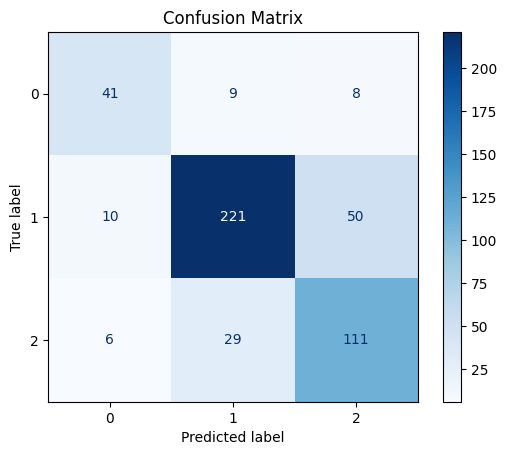

In [75]:
seed_everything(0)
embedding_dim=300
n_blocks= 2
n_columns= 3
out_channels = [64, 128]
kernel_size= 3
local_drop_prob=0.3
drop_prob=0.0
global_drop_prob=0.5
mlp_hidden_dims=[128, 128]
dropout=0.1


num_epoch = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = NewsModel(
        embedding_dim=embedding_dim,
        n_blocks=n_blocks,
        n_columns=n_columns,
        out_channels=out_channels,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
        mlp_hidden_dims=mlp_hidden_dims,
        dropout=dropout,
    ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

train(model, train_loader, val_loader, num_epoch, optimizer, criterion, device)
test_model(model, test_loader, device, 'fractal_50.png')
torch.save(model.state_dict(), 'fractal-attn.pth')

Block 1, Input channels: 300, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 6
Epoch 1/100:
  Train Precision: 0.5100, Recall: 0.4664, F1: 0.4662
  Val Precision: 0.6011, Recall: 0.6270, F1: 0.5559
Epoch 50/100:
  Train Precision: 0.9323, Recall: 0.9276, F1: 0.9283
  Val Precision: 0.7658, Recall: 0.7689, F1: 0.7669
Epoch 100/100:
  Train Precision: 0.9695, Recall: 0.9681, F1: 0.9684
  Val Precision: 0.7780, Recall: 0.7803, F1: 0.7783
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.64      0.69        58
           1       0.81      0.82      0.81       281
           2       0.66      0.67      0.66       146

    accuracy                           0.75       485
   macro avg       0.74      0.71      0.72       485
weighted avg       0.75      0.75      0.75       485



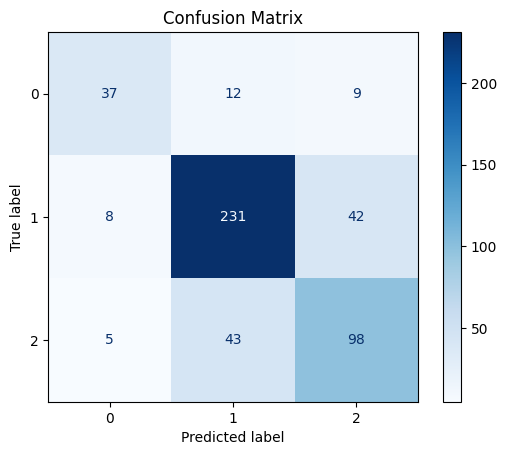

In [76]:
seed_everything(0)
embedding_dim=300
n_blocks= 3
n_columns= 2
out_channels = [32, 64, 128]
kernel_size= 3
local_drop_prob=0.5
drop_prob=0.0
global_drop_prob=0.0
mlp_hidden_dims=[128, 128]
dropout=0.3
lstm_layers=1

num_epoch = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = NewsModel(
        embedding_dim=embedding_dim,
        n_blocks=n_blocks,
        n_columns=n_columns,
        out_channels=out_channels,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
        mlp_hidden_dims=mlp_hidden_dims,
        dropout=dropout,
    ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

train(model, train_loader, val_loader, num_epoch, optimizer, criterion, device)
test_model(model, test_loader, device, 'fractal_100.png')

# Test BERT

In [37]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv', encoding='latin1', header=None, names=['label', 'headline'])  

encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 32

encodings = tokenizer(list(df['headline']), truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors='pt')
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']
labels = torch.tensor(df['label'].values)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [41]:
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
    input_ids, labels, attention_mask, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    X_train, y_train, mask_train, test_size=0.1, random_state=42)

train_dataset = TensorDataset(X_train, mask_train, y_train)
val_dataset = TensorDataset(X_val, mask_val, y_val)
test_dataset = TensorDataset(X_test, mask_test, y_test)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [42]:
class BertBaseClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_classes) 

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = output.last_hidden_state[:, 0, :] 
        return self.classifier(self.dropout(cls_output))

In [45]:
def train_epoch(model, dataloader):
    model.train()
    total_loss, correct = 0, 0
    for input_ids, mask, labels in dataloader:
        input_ids, mask, labels = input_ids.to(device), mask.to(device), labels.to(device)
        outputs = model(input_ids, mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)

def eval_epoch(model, dataloader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for input_ids, mask, labels in dataloader:
            input_ids, mask, labels = input_ids.to(device), mask.to(device), labels.to(device)
            outputs = model(input_ids, mask)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(encoder.classes_)
model = BertBaseClassifier(num_classes).to(device)

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train.numpy()), y=y_train.numpy())
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

for epoch in range(2):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = eval_epoch(model, val_loader)
    print(f"Epoch {epoch+1}: Train loss {train_loss:.4f}, acc {train_acc:.4f} | Val loss {val_loss:.4f}, acc {val_acc:.4f}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Train loss 0.6979, acc 0.6700 | Val loss 0.4254, acc 0.8009
Epoch 2: Train loss 0.3449, acc 0.8451 | Val loss 0.4233, acc 0.8192


In [46]:
def evaluate_model(model, dataloader, device, label_encoder, name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig(name, dpi=300, bbox_inches='tight')
    plt.show()

Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.88      0.78        58
     neutral       0.90      0.84      0.87       281
    positive       0.75      0.78      0.77       146

    accuracy                           0.82       485
   macro avg       0.78      0.83      0.80       485
weighted avg       0.83      0.82      0.83       485



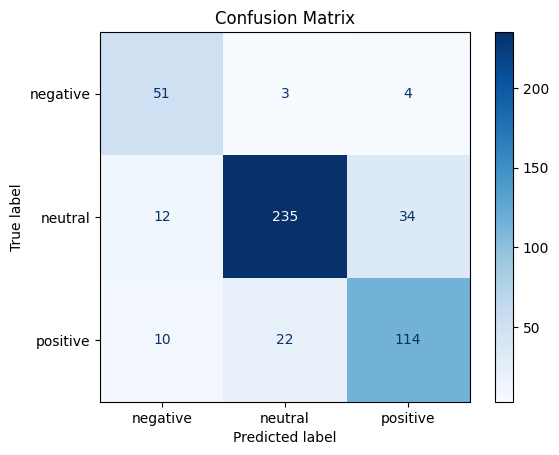

In [47]:
evaluate_model(model, test_loader, device, encoder, 'bert.png')

# Test FinBERT

In [48]:
class FinBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained("yiyanghkust/finbert-tone")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(self.dropout(cls_output))

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(encoder.classes_)
model = FinBERTClassifier(num_classes).to(device)

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train.numpy()), y=y_train.numpy())
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

for epoch in range(3):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = eval_epoch(model, val_loader)
    print(f"Epoch {epoch+1}: Train loss {train_loss:.4f}, acc {train_acc:.4f} | Val loss {val_loss:.4f}, acc {val_acc:.4f}")

Epoch 1: Train loss 1.0705, acc 0.4623 | Val loss 1.0356, acc 0.5263
Epoch 2: Train loss 0.8726, acc 0.6060 | Val loss 0.8806, acc 0.5515
Epoch 3: Train loss 0.6398, acc 0.7255 | Val loss 0.8633, acc 0.6796


Classification Report:
              precision    recall  f1-score   support

    negative       0.48      0.50      0.49        58
     neutral       0.79      0.74      0.77       281
    positive       0.58      0.64      0.61       146

    accuracy                           0.68       485
   macro avg       0.62      0.63      0.62       485
weighted avg       0.69      0.68      0.69       485



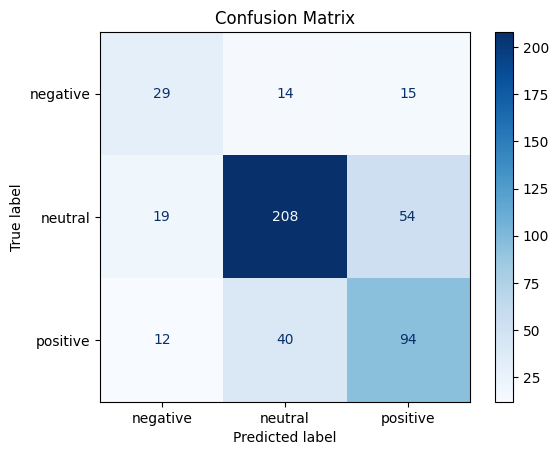

In [54]:
evaluate_model(model, test_loader, device, encoder, 'finbert.png')